# Case Study: Math PhD Exchange

This data set is derived from the article ["Eigenvector-Based Centrality Measures for Temporal Networks
"](https://arxiv.org/abs/1507.01266) by Taylor, Myers, Clauset, Porter, and Mucha, which was in turn scraped from the [Mathematics Geneology Project](https://www.genealogy.math.ndsu.nodak.edu/). There is an entry $i\rightarrow j$ in year $t$ if a mathematician graduated in year $t$ from university $j$ and thereafter supervised at least one PhD thesis at university $i$. This is a proxy for hiring data: we are assuming, essentially, that this mathematician was hired ("endorsed") by $i$ in or around year $t$. 

## Data Limitations

There are several limitations in these data implied by the collection process. 

1. If a mathematician is hired in year $t$, then they are unlikely to show up in the data set until roughly year $t+\tau$, where $\tau\approx 5 \pm 2$ is the approximate amount of time required to complete a PhD thesis. 
2. If a mathematician is hired sequentially by departments $i$ and $i'$, both $i$ and $i'$ will be taken to have endorsed this mathematician *in the same year* $t$, even though the actual time in which $i'$ hired the mathematician may be well after $i$. This raises the potential for causality violations. 

To address limitation 1., we omit the final six years of the data set. We'll study the years 1960-2000. 

In [1]:
import numpy as np

from py.simulation import *
from py.estimation import *
from py.features import *
from py.utils import *
from py.prep_data import *
from py.model import model

# visualization

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
from matplotlib.gridspec import GridSpec


# Data Preparation

First we read the data. In order to ensure connectedness of the endorsement matrix across many time periods, we restrict the data to only the top 100 schools by placement. 

In [2]:
t_start = 0
group = 'G2'

T, timesteps, labels = prep_parakeets('data/parakeet/', group = group)
T, timesteps, A0, n_obs = initial_condition(T, timesteps, t_start = t_start)

n = len(labels)

In [3]:
n_obs

961.0

# Inference

Now we're ready to try to learn the model on some data. In the paper, the instantaneous rate of endorsements to $j$ is given by $\gamma_j \propto e^{\beta s_j}$. This rate is independent of the identity of the endorser. 

The model used here is an extension in two respects. First, we use a more general rate $\gamma$ that depends on the identity of both the endorser and the endorsed: 

$$\gamma_{ij} \propto e^{\beta_1s_j + \beta_2 (s_i - s_j)^2}$$

The incorporation of the quadratic term in the exponent governs a tendency for agents to endorse each other when they are nearby in the hierarchy. If $\beta_1$ is negative, endorsements that span large swaths of rank-space are discouraged. For example, in the context of faculty hiring, negative values of $-\beta_2$ would discourage cases in which a very low-ranked school was able to hire a candidate from a very high-ranked school. The model that we have been considering can be recovered by fixing $\beta_2 = 0$. 

Second, we also consider a version of this model in which, instead of $s_j$ denoting the SpringRank of $j$, we set $s_j = \sqrt{d_j}$. In this case, it doesn't matter "where" you are in the hierarchy, only the total number of endorsements you've received. 

The result of SpringRank-based inference is:

In [4]:
L_SR = model()

L_SR.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T + .0001, alpha = .01)
)

linear_feature = lambda s: np.tile(s, (n,1))

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

L_SR.set_features([
    linear_feature, 
    quadratic_feature
])

L_SR.set_data(T, A0)

pars_SR = L_SR.ML(lam0 = .8, 
           alpha0 = 10**(-4), 
           tol = 10**(-4), 
           step_cap = .05,
           print_updates = False)
pars_SR

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.40454417868550085,
 'beta': array([ 2.86199789, -1.45852572]),
 'LL': -2446.745611528072}

The result of degree-based inference is: 

In [5]:
# degree-based inference: this call should be faster

L_deg = model()

L_deg.set_score(
    score_function = lambda A: A.sum(axis = 0)
)

L_deg.set_features([
    lambda s: linear_feature(np.sqrt(s)), 
    lambda s: quadratic_feature(np.sqrt(s))
])

L_deg.set_data(T, A0)


pars_deg = L_deg.ML(lam0 = .0, 
           alpha0 = 10**(-1), 
           tol = 10**(-10), 
           step_cap = .05,
           print_updates = False)
pars_deg

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.4010249622697968,
 'beta': array([ 0.61634319, -0.06440427]),
 'LL': -2498.106637331578}

In [6]:
# pagerank!

L_PR = model()

def pagerank(A, alpha = 0.15, n_iter = 200): 
    n = A.shape[0]
    A = A + .0001
    A = A.T/(A.T).sum(axis = 0)[:,np.newaxis]
    M = (1-alpha)*A + alpha/n
    
    v = np.random.rand(n)
    for i in range(n_iter):
        v = M.dot(v)
    return(v/v.sum())
    
L_PR.set_score(
    score_function = pagerank
)

L_PR.set_features([
    linear_feature, 
    quadratic_feature
])

L_PR.set_data(T, A0)

pars_PR = L_PR.ML(lam0 = .5, 
           alpha0 = 10**(-1), 
           tol = 10**(-6), 
           step_cap = .05,
           print_updates = False)
pars_PR

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.970352938781213,
 'beta': array([ 28.64300859, -37.45472594]),
 'LL': -2714.0194053148616}

In [16]:
L_L = model()

def fiedler_vector(A):
    A = (A + A.T)/2 + .01
    D = np.diag(A.sum(axis = 1))
    L = D - A
    eig = np.linalg.eigh(L)
    v = eig[1][:,1]
    if v[0] < 0:
        v = -v
    return(v)

L_L.set_score(
    score_function = fiedler_vector
)

L_L.set_features([
    lambda s: linear_feature(s), 
    lambda s: quadratic_feature(s)
])

L_L.set_data(T, A0)

pars_L = L_L.ML(lam0 = .9, 
           alpha0 = 10**(-2), 
           tol = 10**(-3), 
           step_cap = .1,
           print_updates = False)
pars_L

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.7636048777903852,
 'beta': array([ 0.27890029, -1.85903016]),
 'LL': -2798.3055667855733}

In [15]:
L_K = model()

# @jit(nopython=True)
def katz_score(A, alpha = .001):
    n = A.shape[0]
    e = np.ones(n)
    I = np.eye(n,n)
    return(np.linalg.inv(I - alpha*A).dot(e))

L_K.set_score(
    score_function = lambda A: katz_score(A.T, alpha = .04)
)

L_K.set_features([
    lambda s: linear_feature(s), 
    lambda s: quadratic_feature(s)
])

L_K.set_data(T, A0)

pars_K = L_K.ML(lam0 = 0.5, 
           alpha0 = 10**(-2), 
           tol = 10**(-6), 
           step_cap = .1,
           print_updates = False)
pars_K

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.28049699270268325,
 'beta': array([ 1.07104754, -0.21560969]),
 'LL': -2492.818708752052}

These results suggest that the degree-based feature model may be preferable to the SpringRank model, based on its higher log-likelihood (LL). Other points to note are that the models give very similar estimates for $\lambda$, indicating that they agree on the relevant timescales for prediction in these data. 

Let's proceed with the degree-based parameters. 

In [222]:
# batch standard errors

d = {
    'SR': [L_SR, pars_SR],
    'deg': [L_deg, pars_deg], 
    'PR': [L_PR, pars_PR]
}

for key in d: 
    L = d[key][0]
    pars = d[key][1]
    H = L.estimate_hessian(pars['lam'], pars['beta'])
    V = np.linalg.inv(-H) # covariance matrix
    print(key + ': ' + str(np.round(np.sqrt(np.diag(V)), 3)))

SR: [0.058 0.141 0.115]
deg: [0.07  0.031 0.008]
PR: [0.029 2.382 3.272]


In [170]:
pars = pars_SR
L = L_SR

# Parameter Uncertainty

Now let's estimate the covariance matrix of the parameters by inverting the Hessian matrix of the likelihood function at the parameters we solved for. 

In [171]:
# again might take a little while

H = L.estimate_hessian(pars['lam'], pars['beta'])
V = np.linalg.inv(-H) # covariance matrix
np.sqrt(np.diag(V))

array([0.14125512, 0.16269193, 0.11929583])

In [149]:
pars['beta']

array([ 2.86199789, -1.45852572])

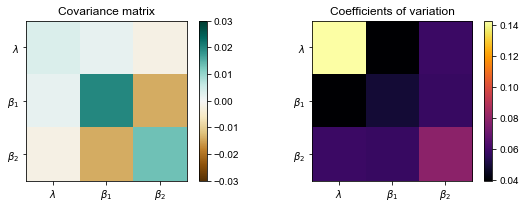

In [150]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)
im = ax.imshow(V, cmap = 'BrBG', vmin = -0.03, vmax = 0.03) # estimated covariance matrix
plt.colorbar(im)
t = ax.set_title('Covariance matrix')
plt.xticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])
plt.yticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])

ax = fig.add_subplot(122)
p = np.concatenate(([pars['lam']], pars['beta']))
im = ax.imshow(np.sqrt(V/np.outer(p,p)), cmap = 'inferno')    # coefficient of variation
plt.colorbar(im)

plt.xticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])
plt.yticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])

t = ax.set_title('Coefficients of variation')

plt.tight_layout()

plt.savefig('fig/parakeet_cv.png', dpi = 300)

The model is extremely confident about its prediction in $\lambda$, indicated by the fact that the rows and columns corresponding to $\lambda$ are very small. There is a negative correlation between $\beta_1$ and $\beta_2$, indicating that there are regions of parameter space that are "nearly as good" (as measured by the likelihood) in which $\beta_1$ is smaller and $\beta_2$ is larger, or vice-versa. 

How "big" is the covariance matrix relative to the data? Not too large! The coefficients of variation for each pair of variables are all well below $5\%$, indicating that we can be roughly 95% confidence of our estimates within 10% accuracy or better. The greatest amount of relative uncertainty is in the estimate of $\beta_2$. 

While this is a highly informal approach and should not be confused with actual statistics, the small coefficients of variation are heuristic evidence that all the parameters are significantly different from zero. 

# Snapshot of model prediction

The mini-study below considers how the model ''works.'' 

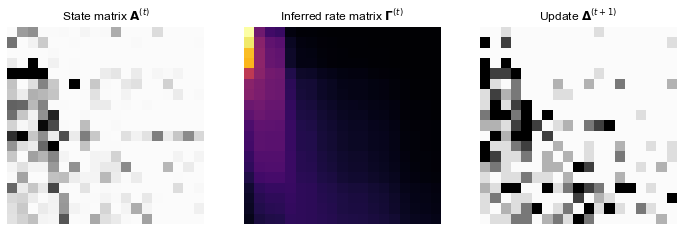

In [151]:
# snapshot of the state and cumulative hiring matrix at specified time i

# A = state_matrix(T, A0 = A0, lam = pars['lam'])

# S = SR_quadratic_feature(A)

i = 2

V = L.GAMMA[i]
# V = softmax(S, np.array([2.8, 0]))[i]

fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(131)
ax.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(L.A[i], -L.A[i].sum(axis = 0)), vmax = 5,  cmap = 'Greys', alpha = .99)
ax.set(title = r'State matrix $\mathbf{A}^{(t)}$')
ax.axis('off')

ax = fig.add_subplot(132)
# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), alpha = .995, cmap = 'inferno', vmax = .5)
ax.set(title = 'Inferred rate matrix $\mathbf{\Gamma}^{(t)}$')
plt.gca().axis('off')

ax = fig.add_subplot(133)
ax.imshow(np.ones_like(T[i]), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(T[i+1]-T[i], -V.sum(axis = 0)), vmax = 5,  cmap = 'Greys', alpha = .99)
ax.set(title = 'Update $\mathbf{\Delta}^{(t+1)}$')
ax.axis('off')
# plt.colorbar()

plt.savefig('fig/parakeet_illustration.png', dpi = 300, bbox_inches = 'tight')

On the far left, we show the model state $A_t$ at time $t = 30$. Each entry of this matrix is a weighted sum of previous hiring events: $A_{ij}^{(t)} = \sum_{\tau = 1}^t \lambda^\tau E_{ij}^{(\tau)}$, where $E_{ij}^{(\tau)}$ is the number of times $i$ endorsed $j$ in time period $\tau$. This matrix is an input into the rate matrix $\Gamma$, which is shown in the center. This is a matrix of predictions about endorsements in the next time-step: entry $\gamma_{ij}$ is proportional to the predicted probability that $i$ will endorse $j$ in the next timestep. Finally, we can (heuristically) compare the rate matrix to the observed update at time $t+1$, noting that the bulk of endorsement events do indeed occur in regions of high probability specified by the rate matrix. 

# Inferred rank dynamics

Now let's visualize the evolution of this system as understood by the model. It's of possible interest to visualize at least two distinct objects. The first is the overall modeled endorsement rate, which predicts the rate of endorsements of $j$ in the next timestep. The second is the intrinsic ranks modeled for each individual school. 

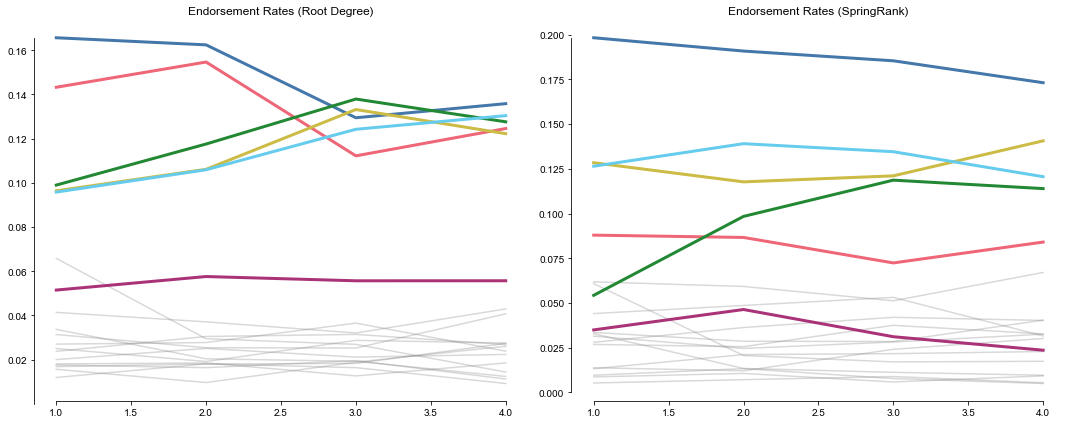

In [152]:
fig = plt.figure(figsize = (15,6))

# FIRST PLOT

ax = fig.add_subplot(121)

# A = state_matrix(T, A0 = A0, lam = pars['lam'])
# S = feature_fun(A)

GAMMA = L_deg.GAMMA.mean(axis = 1)

top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]


# for i in range(6, top_n):
p = ax.plot(timesteps, GAMMA, color = 'grey', alpha = .3)

k = 0
for i in top_trajectories:
    ax.plot(timesteps, GAMMA[:,i], color = cset[k], alpha = 1, linewidth = 3)
    k += 1


# for l in range(n):
#     long_name = labels[l]
#     if long_name in shortener: 
#         name = shortener[long_name]
#         if name in highlight:         
#             ax.plot(timesteps, GAMMA[:,l], alpha = 1, linewidth = 3, 
#                      label = name, color = cset[k])

#             ax.annotate(shortener[labels[l]],
#                       xy=(timesteps.max(), GAMMA[-1:,l] + label_adjustments[name]), xycoords='data',
#                       xytext=(10, 0), textcoords='offset points',
#                       size=12, va="center", color = 'black',
#                       bbox=dict(boxstyle="round",  color = cset[k], alpha = .4))
        
#             k += 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds(0, GAMMA.max())
ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())

ax.set(title = 'Endorsement Rates (Root Degree)')


# SECOND PLOT

ax = fig.add_subplot(122)

GAMMA = L_SR.GAMMA.mean(axis = 1)

# top_trajectories = np.unique(GAMMA.argmax(axis = 1))
# top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# GAMMA = np.sort(GAMMA, axis = 1)
# for i in range(6, top_n):
p = ax.plot(timesteps, GAMMA, color = 'grey', alpha = .3)

k = 0
for i in top_trajectories:
    ax.plot(timesteps, GAMMA[:,i], color = cset[k], alpha = 1, linewidth = 3)
    k += 1

# k = 0
# for i in top_trajectories:
#     ax.plot(timesteps, GAMMA[:,i], color = cset[k], alpha = 1)
#     k += 1
# k = 0


# k = 0

# for l in range(n):
#     long_name = labels[l]
#     if long_name in shortener: 
#         name = shortener[long_name]
#         if name in highlight:         
#             ax.plot(timesteps, GAMMA[:,l], alpha = 1, linewidth = 3, 
#                      label = name, color = cset[k])

#             ax.annotate(shortener[labels[l]],
#                       xy=(timesteps.max(), GAMMA[-1:,l] + label_adjustments[name]), xycoords='data',
#                       xytext=(10, 0), textcoords='offset points',
#                       size=12, va="center", color = 'black',
#                       bbox=dict(boxstyle="round",  color = cset[k], alpha = .4))
        
#             k += 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds(0, GAMMA.max())
ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())

ax.set(title = 'Endorsement Rates (SpringRank)')

plt.tight_layout()

plt.savefig('fig/parakeet_ranks.png', dpi = 300)